# The Battle of Neigborhoods (Week 2)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction/Business Problem <a name="introduction"></a>

__Madrid__ and __Barcelona__ are the largest cities in __Spain__. Madrid is the administrative capital and Barcelona the industrial one. The spanish __government__ is interested on __understanding how different or similar__ are these cities in order to study if they can __apply the same actions__ on both cities or not.

For a better understanding of the problem we __first__ study each city __individually__. __Then__, we __compere__ the results on both cities and will try to __find similarities__ between the cities or between districts of the different cities.

The annual __net income per capita__ is a good indicator to distinguish between the __rich and poor districts__ of the city. We can __also__ use as an indicator the __number of services that can generate a good quality of life__. A neighborhood may not have a high income but be well equipped. We are going to consider the following services as indicators of a good quality of life: hospitals and other medical centers, pharmacies, police stations, supermarkets, parks, playgrounds, Athletics & Sports venues, post offices, parking, event spaces, Arts & Entertainment venues, music venues, libraries, cultural centers, music schools and language schools(as an indicator of the education since there are schools and high schools in almost all districts).

## Data <a name="data"></a>

### Data definition and source

In order to study this case we need first to __define the data__ that we need and __find__ the data __sources__. Then, we work on them to __create__ the __dataset__ that we will use for our purpose.

First, we are going to __study the income__ in each district for each city. So, we need to get the information about the income that are distributed geographically. Searching on internet, we found the __income for each postal code in Spain__ in 2018 being the data source the site https://www.epdata.es/ which is a portal (in spanish) that containts many studies and data sets on population, unemployment, income, crime and many other subjects. The data is stored on a __csv file__. To visualize this information on a map we need the __coordinates of each postal codes__. To do this we need to know the postal codes of each city, the information was found on the site http://es.postcode.info/ and then we get the coordinates using the geocoder python library for these postal codes.

Second, to study the venues in each district of the city. For this porpuse we will use the __FourSquare__ API to get the information needed. Knowing the coordinates of each district we can explore the selected venues of any type around.

In our study we will plot data about the different districts on a map, so we will need two __json files with the geographical districts limits__ for each city. We found some files on the internet but they need some modifications to fit our problem (this is why I'm not giving the source)

#### A) Incomes per district

In [1]:
import pandas as pd
import geocoder#get coordinates

After downloding the file with the annual mean income for all postal codes we load it on a pandas data frame to have a lok on the data.

In [2]:
spain_income_df = pd.read_csv('income_spain.csv')
spain_income_df.head()

,Year,Period,Parameter,Gross mean income,Net mean income
0,2018,Año,"02001-San Antonio Abad, La Pajarita, Polígono ...",32036,25823
1,2018,Año,"02002-Parque Sur, Huerta de Marzo (Albacete)",30426,24615
2,2018,Año,02003-Franciscanos (Albacete),26866,22145
3,2018,Año,"02004-Fátima, Villacerrada (Albacete)",23072,19449
4,2018,Año,"02005-Industria, El Pilar, Feria, Ntra Sra de ...",25098,20822


Since all the data is for the year 2018 we can drop the columns Period and Year because they don't give us any information. We also drop the Gross income column since we will be working on the __Net income__.

We can observe that the Parameter column has information about the __postal code__ and the __neighborhoods__ related to this postal code. We need to split this information in different columns to work with them later.

In [3]:
spain_income_df.drop(['Year', 'Period', 'Gross mean income'], axis=1, inplace=True)
spain_income_df[['postal_code','neighborhoods']] = spain_income_df.Parameter.str.split("-",expand=True)
spain_income_df.drop(['Parameter'], axis=1, inplace=True)

Now, __we need to related the postal codes with coordinates__ to be able later to plot on the maps. Here we difine a function that will help us to get the coordinates for each postal code.

In [4]:
def get_geocoder(postal_code):
    city = None
    if postal_code.startswith('280'):
        city = '{}, Madrid, Spain'
    else:
        city = '{}, Barcelona, Spain'
     # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis(city.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

We load and prepare the files with the postal codes for each city. Then, we merge separtly both of them with the income dataframe to create a __different dataframe for each city__.

In [5]:
postal_codes_madrid = pd.read_csv('Madrid_postal_codes_formatted.csv')
postal_codes_barcelona = pd.read_csv('Barcelona_postal_codes_formatted.csv')
postal_codes_madrid[['postal_code','dummy']] = postal_codes_madrid.postalcode.str.split("-",expand=True)
postal_codes_barcelona[['postal_code','dummy']] = postal_codes_barcelona.postalcode.str.split("-",expand=True)
postal_codes_madrid.drop(['dummy', 'postalcode'], axis=1, inplace=True)
postal_codes_barcelona.drop(['dummy', 'postalcode'], axis=1, inplace=True)

In [6]:
madrid_df = spain_income_df.merge(postal_codes_madrid, how='inner', left_on=['postal_code'], right_on=['postal_code'])
barcelona_df = spain_income_df.merge(postal_codes_barcelona, how='inner', left_on=['postal_code'], right_on=['postal_code'])

And we get the coordinates using the function previously defined

In [7]:
madrid_df['Latitude'], madrid_df['Longitude'] = zip(*madrid_df['postal_code'].apply(get_geocoder))
barcelona_df['Latitude'], barcelona_df['Longitude'] = zip(*barcelona_df['postal_code'].apply(get_geocoder))

In [8]:
madrid_df.head()

,Net mean income,postal_code,neighborhoods,city,Latitude,Longitude
0,71599,28001,"Salamanca, Goya (Madrid)",Madrid,40.424870,-3.682793
1,43426,28002,Chamartín (Madrid),Madrid,40.445035,-3.673343
2,41968,28003,"Chamberí, Rios Rosas (Madrid)",Madrid,40.442985,-3.705943
3,35353,28004,Justicia (Madrid),Madrid,40.424445,-3.699007
4,30078,28005,Arganzuela (Madrid),Madrid,40.405675,-3.712948


In [9]:
barcelona_df.head()

,Net mean income,postal_code,neighborhoods,city,Latitude,Longitude
0,19437,08001,"Ciutat Vella, El Raval (Barcelona)",Barcelona,41.380160,2.168716
1,26177,08002,Barrio Gótico (Barcelona),Barcelona,41.382180,2.176718
2,25768,08003,Barceloneta y Sant Pere (Barcelona),Barcelona,41.383210,2.187879
3,22526,08004,Pueblo Seco (Barcelona),Barcelona,41.370435,2.159972
4,30604,08005,El Poblenou (Barcelona),Barcelona,41.396235,2.201388


And we can store these data

In [10]:
#to store the data set on a csv file
madrid_df.to_csv("madrid_neig_coord.csv")
barcelona_df.to_csv("barcelona_neig_coord.csv")

We didn't find any site where were related the different postal codes to the districts. But we now which neigborhoods are in each districts. So we just include this information on the file where we have stored before. And __load a new file updated with the distircts__.

In [11]:
madird_w_districts = pd.read_csv('madrid_with_districts.csv')
barcelona_w_districts = pd.read_csv('barcelona_with_districts.csv')
madird_w_districts.drop(['Unnamed: 0', 'neighborhood'], axis =1, inplace=True)
barcelona_w_districts.drop(['Unnamed: 0', 'neighborhood'], axis =1, inplace=True)
madird_w_districts.sort_values(by='district', ascending=True, inplace=True)
barcelona_w_districts.sort_values(by='district', ascending=True, inplace=True)
madird_w_districts = madird_w_districts.groupby("district").mean()
barcelona_w_districts = barcelona_w_districts.groupby("district").mean()
madird_w_districts.reset_index(level=0,inplace=True)
barcelona_w_districts.reset_index(level=0,inplace=True)

In [12]:
madird_w_districts.head()

,district,Net mean income,Latitude,Longitude
0,Arganzuela,29817.000000,40.399677,-3.700679
1,Barajas,36363.000000,40.475000,-3.575500
2,Carabanchel,22859.333333,40.382017,-3.745679
3,Centro,32649.750000,40.420799,-3.704535
4,Chamartin,54030.000000,40.462981,-3.679981


In [13]:
barcelona_w_districts.head()

,district,Net mean income,Latitude,Longitude
0,Ciutat Vella,24702.000000,41.387212,2.181133
1,Eixample,38479.700000,41.392281,2.159918
2,Gracia,30870.333333,41.408921,2.152820
3,Horta Guinardo,17905.000000,41.425165,2.158162
4,Les Corts,48995.500000,41.386218,2.117649


#### B) Venues per district

For __each city__, we get __all the near defined venues__ in the introduction for __each districts__. Then we sump up the results and create a data frame with the total number of these venues in a district, and the district coordinates. 

The __url to hit the Foursquare API__ for each district will be like:

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            categoryid,
            LIMIT)

__For simplicity's sake We are not going to show the code, We are just going to load from a file where we have saved the information after doing all the data preparation.__

The __files__ with the total number of venues for each district:

In [14]:
Madrid_district_venues_df = pd.read_csv('madrid_data.csv')
Barcelona_district_venues_df = pd.read_csv('barcelona_data.csv')
Madrid_district_venues_df.drop(['Unnamed: 0'],axis=1,inplace=True)
Barcelona_district_venues_df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [15]:
Madrid_district_venues_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,language school,park,athletic and sport,playground,parking,post office,supermarket,...,hospital,art and entertainment,library,medical center,police station,event space,cultural center,music venue,music school,total
0,Arganzuela,40.399677,-3.700679,4,9,25,6,6,4,17,...,0,39,6,28,5,7,3,6,1,175
1,Barajas,40.475000,-3.575500,0,0,4,2,1,3,1,...,0,2,0,15,0,2,1,1,1,38
2,Carabanchel,40.382017,-3.745679,0,6,4,0,0,3,3,...,8,4,1,10,4,3,0,7,0,61
3,Centro,40.420799,-3.704535,2,11,41,5,28,17,41,...,3,92,10,36,4,15,2,49,5,417
4,Chamartin,40.462981,-3.679981,3,5,13,2,3,6,6,...,5,5,0,33,2,7,3,2,0,100


In [16]:
Barcelona_district_venues_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,language school,park,athletic and sport,playground,parking,post office,supermarket,...,hospital,art and entertainment,library,medical center,police station,event space,cultural center,music venue,music school,total
0,Ciutat Vella,41.387212,2.181133,3,8,32,2,14,5,30,...,5,81,9,20,4,17,7,22,4,292
1,Eixample,41.392281,2.159918,10,14,43,6,26,8,37,...,15,57,5,40,9,20,5,17,3,372
2,Gracia,41.408921,2.152820,1,11,12,3,6,3,22,...,9,32,2,25,1,6,4,9,5,170
3,Horta Guinardo,41.425165,2.158162,4,6,6,1,0,3,5,...,4,4,1,6,0,3,4,3,2,69
4,Les Corts,41.386217,2.117649,4,12,20,3,8,3,8,...,8,3,1,27,0,3,2,1,1,113


And the files __to create the clusters__ with the top 10 venues for each district. It is a similar process to the previous one but we extend the venues to other more general categories and we don't sum up the count of the different venue categories:

In [17]:
Madrid_grouped_df = pd.read_csv('madrid_grouped.csv')
Barcelona_grouped_df = pd.read_csv('barcelona_grouped.csv')
Madrid_grouped_df.drop(['Unnamed: 0'],axis=1,inplace=True)
Barcelona_grouped_df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [18]:
Madrid_grouped_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Alternative Healer,Amphitheater,Art Gallery,Art Museum,Arts & Entertainment,Athletics & Sports,Bar,...,Science Museum,Skate Park,Skating Rink,Soccer Field,Sports Club,Supermarket,Tennis Court,Theater,Veterinarian,Yoga Studio
0,Arganzuela,40.399677,-3.700679,0.000000,0.0,0.051429,0.011429,0.0,0.011429,0.00,...,0.005714,0.011429,0.005714,0.005714,0.000000,0.097143,0.005714,0.045714,0.017143,0.017143
1,Barajas,40.475000,-3.575500,0.000000,0.0,0.026316,0.000000,0.0,0.000000,0.00,...,0.000000,0.026316,0.000000,0.026316,0.000000,0.026316,0.000000,0.026316,0.078947,0.000000
2,Carabanchel,40.382017,-3.745679,0.000000,0.0,0.000000,0.000000,0.0,0.016393,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.049180,0.000000,0.000000,0.016393,0.000000
3,Centro,40.420799,-3.704535,0.002398,0.0,0.011990,0.021583,0.0,0.009592,0.00,...,0.000000,0.000000,0.000000,0.000000,0.002398,0.086331,0.000000,0.047962,0.004796,0.019185
4,Chamartin,40.462981,-3.679981,0.000000,0.0,0.020000,0.000000,0.0,0.020000,0.01,...,0.000000,0.000000,0.010000,0.000000,0.000000,0.060000,0.000000,0.000000,0.020000,0.010000


In [19]:
Barcelona_grouped_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Alternative Healer,Amphitheater,Art Gallery,Art Museum,Arts & Entertainment,Athletics & Sports,Bar,...,Science Museum,Skate Park,Skating Rink,Soccer Field,Sports Club,Supermarket,Tennis Court,Theater,Veterinarian,Yoga Studio
0,Ciutat Vella,41.387212,2.181133,0.0,0.0,0.075342,0.017123,0.0,0.006849,0.010274,...,0.00000,0.003425,0.006849,0.003425,0.000000,0.099315,0.000000,0.027397,0.003425,0.017123
1,Eixample,41.392281,2.159918,0.0,0.0,0.037634,0.010753,0.0,0.008065,0.000000,...,0.00000,0.000000,0.000000,0.002688,0.000000,0.091398,0.000000,0.018817,0.008065,0.018817
2,Gracia,41.408921,2.152820,0.0,0.0,0.023529,0.005882,0.0,0.011765,0.000000,...,0.00000,0.000000,0.000000,0.017647,0.000000,0.129412,0.005882,0.047059,0.005882,0.005882
3,Horta Guinardo,41.425165,2.158162,0.0,0.0,0.014493,0.000000,0.0,0.014493,0.000000,...,0.00000,0.000000,0.000000,0.014493,0.014493,0.072464,0.000000,0.000000,0.000000,0.000000
4,Les Corts,41.386217,2.117649,0.0,0.0,0.000000,0.000000,0.0,0.026549,0.000000,...,0.00885,0.000000,0.000000,0.044248,0.008850,0.061947,0.026549,0.000000,0.000000,0.000000


## Methodology <a name="methodology"></a>

To easily __identify__ the __quality__ of the life in each __district__, we will plot the data using a __choropleth map__ for the __income__ and for the __total number of "quality" venues__. We will discuss the insights for each city trying to understand where are a __good standard of living__.

Then, we can __group__ each __district__ into clusters with __similar characteristics__. Like ths we can find which districts are similar inside each city, and how if there are similar districts between the cities.

With this information we will be able to __decide if we can take common actions__ in both cities and which __actions__ we could take in order to __improve__ the standard of living in the __poor districts__.

## Analysis <a name="analysis"></a>

In [20]:
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

We have the net mean __income for each district__ for both cities together with the district __coordinates__, so we can plot a __choropleth map__ to visualize the __geographical income distribution__ having a better understanding on how the wealth is distributed inside each city.

We get the coordinates for each city using the the geocoder

In [21]:
address_madrid = 'Madrid, Spain'
address_barcelona = 'Barcelona, Spain'
geolocator = Nominatim(user_agent="ny_explorer")
location_mad = geolocator.geocode(address_madrid)
latitude_mad = location_mad.latitude
longitude_mad = location_mad.longitude
location_bcn = geolocator.geocode(address_barcelona)
latitude_bcn = location_bcn.latitude
longitude_bcn = location_bcn.longitude

print('The geograpical coordinate of Madrid City are {}, {}.'.format(latitude_mad, longitude_mad))
print('The geograpical coordinate of Barcelona City are {}, {}.'.format(latitude_bcn, longitude_bcn))

The geograpical coordinate of Madrid City are 40.4167047, -3.7035825.
The geograpical coordinate of Barcelona City are 41.3828939, 2.1774322.


__Initialize the maps__ for Madrid and Barcelona

In [22]:
madrid_income_map = folium.Map(location=[latitude_mad, longitude_mad], zoom_start=11)
barcelona_income_map = folium.Map(location=[latitude_bcn, longitude_bcn], zoom_start=12)

__Link the data__ with the maps

In [23]:
madrid_income_map.choropleth(
    geo_data=r'madrid.json',
    data=madird_w_districts,
    columns=['district', 'Net mean income'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Madrid average income in euros',
    reset=True
)

barcelona_income_map.choropleth(
    geo_data=r'barcelona.json',
    data=barcelona_w_districts,
    columns=['district', 'Net mean income'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Barcelona average income in euros',
    reset=True
)

__Add the markers__ for each map

In [24]:
# add markers to map
for lat, lng, district, income in zip(madird_w_districts['Latitude'], madird_w_districts['Longitude'], madird_w_districts['district'], madird_w_districts['Net mean income']):
    label = '{}, {} Eur'.format(district, str(round(income)))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(madrid_income_map) 
    
# add markers to map
for lat, lng, district, income in zip(barcelona_w_districts['Latitude'], barcelona_w_districts['Longitude'], barcelona_w_districts['district'], barcelona_w_districts['Net mean income']):
    label = '{}, {} Eur'.format(district, str(round(income)))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(barcelona_income_map) 

__Madrid net mean income by district__

In [25]:
madrid_income_map

__Barcelona net mean income by district__

In [26]:
barcelona_income_map

We can identify the wealthy and poorest districts in both cities. The __wealthy__ districts in __Madrid__ are __Salamanca__(57879 Eur), __Chamartin__(54030 Eur), __Moncloa-Aravaca__(51101.33 Eur) and __poorest__ are __Puente de Vallecas__(17795 Eur), __Tetuan__(18031 Eur) and __Villaverde__ (19709 Eur). The __wealthy__ districts in __Barcelona__ are __Sarria-San Gervasi__(56920 Eur), __Les Corts__(48995.50 Eur) and the __Eixample__(38479.70 Eur) while the __poorest__ are __Sant Andreu__(13699 Eur), __Horta Guinardo__(17905 Eur) and __Nou Barris__(21154.25 Eur)

Using the data from FourSquare we can have a look on __veneus related with the life quality__ and try to understand how them are related to the income distribution. We consider that these venues should be related with __health, education, cultural activities, places where peolpe can feel away from the anxiaty of the city like parks, security and other services__. From all the __venues__ that we can find __on FourSquare__ we have selected the following: park, playground, athletic and sport, parking, post office, police station, pharmacy, medical center, hospital, supermarket, bookstore, library, music venue, cultural center, art and entertainment, event space, music school and language school (these two latest as an indicator for educational services of the district since almost all districts have schools and highschools)

In [27]:
madrid_venues_map = folium.Map(location=[latitude_mad, longitude_mad], zoom_start=11)
barcelona_venues_map = folium.Map(location=[latitude_bcn, longitude_bcn], zoom_start=12)

madrid_venues_map.choropleth(
    geo_data=r'madrid.json',
    data=Madrid_district_venues_df,
    columns=['Neighbourhood', 'total'],
    key_on='feature.properties.name',
    fill_color='YlOrBr', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Madrid total number of venues',
    reset=True
)

barcelona_venues_map.choropleth(
    geo_data=r'barcelona.json',
    data=Barcelona_district_venues_df,
    columns=['Neighbourhood', 'total'],
    key_on='feature.properties.name',
    fill_color='YlOrBr', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Barcelona total number of venues',
    reset=True
)
# add markers to map
for lat, lng, district, total in zip(Madrid_district_venues_df['Neighbourhood Latitude'], Madrid_district_venues_df['Neighbourhood Longitude'], Madrid_district_venues_df['Neighbourhood'], Madrid_district_venues_df['total']):
    label = '{}, {}'.format(district, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(madrid_venues_map) 
    
# add markers to map
for lat, lng, district, total in zip(Barcelona_district_venues_df['Neighbourhood Latitude'], Barcelona_district_venues_df['Neighbourhood Longitude'], Barcelona_district_venues_df['Neighbourhood'], Barcelona_district_venues_df['total']):
    label = '{}, {}'.format(district, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(barcelona_venues_map) 

__Madrid, number of total venues__:

In [28]:
madrid_venues_map

__Barcelona, number of total venues__:

In [29]:
barcelona_venues_map

In the case of __Madrid__, the image is __similar__ to that of __income__ with the exception that one of the richest neighborhoods, Moncloa-Aravaca, which seems to provide less services than the expected for its income level. Opposite one of the poorest district, Tetuan, have more than the expected maybe due to its location.

As for __Barcelona the poor neighborhoods are quite correlated with their income__, while rich neighborhoods have less venues than could correspond to their income being the Eixample an exception.

Looking at the __venues one by one__, it can be seen that there are __venues__ that are __more correlated__ with income and others that are practically not correlated at all. These __correlations can vary between the two cities__. In general, it is observed that for each venue, in most cases, they tend to be concentrated in the neuralgic centers of both cities. Of the two cities, __Barcelona seems better balanced__ since many of the venues are homogeneously distributed throughout the city, while Madrid concentrates the vast majority of venues in the center of the city.

We can select the __most correlated venues and then repeat__ the same process. We select the following venues after inspecting visually each one: 
language school, hospital, medical center, music school, event space, cultural center and athletic and sport (we will shown someof study on the presentation)

In [30]:
madrid_data_reduced = Madrid_district_venues_df.drop(['parking','post office', 'bookstore', 'pharmacy','art and entertainment', 'library', 'police station', 
                                        'music venue', 'playground' ,'supermarket', 'total'], axis=1)
madrid_data_reduced.loc[:,'total'] = madrid_data_reduced[['language school','hospital', 'medical center', 'music school', 'event space',
                                                          'cultural center','athletic and sport']].sum(axis=1)

In [31]:
barcelona_data_reduced = Barcelona_district_venues_df.drop(['parking','post office', 'bookstore', 'pharmacy','art and entertainment', 'library', 'police station', 
                                        'music venue', 'playground' ,'supermarket', 'total'], axis=1)

barcelona_data_reduced.loc[:,'total'] = barcelona_data_reduced[['language school','hospital', 'medical center', 'music school', 'event space',
                                                          'cultural center','athletic and sport']].sum(axis=1)

In [32]:
madrid_venues_resuced_map = folium.Map(location=[latitude_mad, longitude_mad], zoom_start=11)
barcelona_venues_reduced_map = folium.Map(location=[latitude_bcn, longitude_bcn], zoom_start=12)

In [33]:
madrid_venues_resuced_map.choropleth(
    geo_data=r'madrid.json',
    data=madrid_data_reduced,
    columns=['Neighbourhood', 'total'],
    key_on='feature.properties.name',
    fill_color='YlOrBr', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Madrid total number of quality venues reduced',
    reset=True
)

barcelona_venues_reduced_map.choropleth(
    geo_data=r'barcelona.json',
    data=barcelona_data_reduced,
    columns=['Neighbourhood', 'total'],
    key_on='feature.properties.name',
    fill_color='YlOrBr', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Barcelona total number of quality venues reduced',
    reset=True
)
# add markers to map
for lat, lng, district, total in zip(madrid_data_reduced['Neighbourhood Latitude'], madrid_data_reduced['Neighbourhood Longitude'], madrid_data_reduced['Neighbourhood'], madrid_data_reduced['total']):
    label = '{}, {}'.format(district, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(madrid_venues_resuced_map) 
    
# add markers to map
for lat, lng, district, total in zip(barcelona_data_reduced['Neighbourhood Latitude'], barcelona_data_reduced['Neighbourhood Longitude'], barcelona_data_reduced['Neighbourhood'], barcelona_data_reduced['total']):
    label = '{}, {}'.format(district, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(barcelona_venues_reduced_map) 

__Madrid with the most relevant venues__:

In [34]:
madrid_venues_resuced_map

__Barcelona with the most relevant venues__:

In [35]:
barcelona_venues_reduced_map

For this set of venues, Barcelona venues map __match better__ with its __income__ one. In the case of Madrid it's a little better  with the exception of Chamberi district due to its proximity to the center of the city or Moncloa-Aravaca due to its remoteness from the center. 

To understand which districts are similar or to find which kind of venues are lacking in the poorest district we will __continue with this reduced set of venues__.

#### study K value

Again, for simplicity's sake We are not going to show the code droping the unselected columns. Just, as before load a ready file with the data set for each city. Then, since we are interested on understanding the similarities between districts of both cities, we create a data set that result of merging the data sets of both cities.

In [36]:
madrid_grouped_reduced = pd.read_csv('madrid_grouped_reduced.csv')
barcelona_grouped_reduced = pd.read_csv('barcelona_grouped_reduced.csv')
madrid_grouped_reduced.drop(['Unnamed: 0'], axis=1, inplace=True)
barcelona_grouped_reduced.drop(['Unnamed: 0'], axis=1, inplace=True)
madrid_grouped_reduced_no_coor = madrid_grouped_reduced.drop(['Neighbourhood Latitude', 'Neighbourhood Longitude'], axis=1)
barcelona_grouped_reduced_no_coor = barcelona_grouped_reduced.drop(['Neighbourhood Latitude', 'Neighbourhood Longitude'], axis=1)

concat_total_red_frames=[madrid_grouped_reduced_no_coor, barcelona_grouped_reduced_no_coor]
total_grouped_red =pd.concat(concat_total_red_frames)

We still have a __large data set__ with many rows, one per district, and many columns, one for each kind of venue. So to understand the similarity is a good idea to __group the district__ using the __k-means__ machine learning algorithm. The algorithm will find which rows are related based on the similarities of their column values.

__Preeliminar work__

To works with k-means we should __find__ the __best k__ value that fits better the model. We should do this for each data set. As an __example__, we are going to show here the study of the value of k for the __Barcelona__ data set.

We first train the model with a random k value, for example k = 5

In [37]:
# set number of clusters
kclusters_initial = 5

barcelona_grouped_clustering_initial = barcelona_grouped_reduced_no_coor.drop('Neighbourhood', 1)

# run k-means clustering
kmeans_initial = KMeans(n_clusters=kclusters_initial, random_state=0).fit(barcelona_grouped_clustering_initial)

# get the columns labels needed to split the data
barcelona_grouped_clustering_initial.columns

Index(['Alternative Healer', 'Amphitheater', 'Art Gallery', 'Art Museum',
       'Arts & Entertainment', 'Athletics & Sports', 'Basketball Court',
       'Chiropractor', 'Comedy Club', 'Concert Hall', 'Coworking Space',
       'Cultural Center', 'Cycle Studio', 'Dance Studio', 'Dentist's Office',
       'Doctor's Office', 'Emergency Room', 'Escape Room', 'Event Space',
       'Exhibit', 'Eye Doctor', 'Garden', 'Gym', 'Gym / Fitness Center',
       'Gym Pool', 'Gymnastics Gym', 'History Museum', 'Hospital',
       'Indie Movie Theater', 'Indie Theater', 'Jazz Club', 'Language School',
       'Martial Arts School', 'Medical Center', 'Medical Lab',
       'Mental Health Office', 'Miscellaneous Shop', 'Movie Theater',
       'Multiplex', 'Museum', 'Music School', 'Optical Shop',
       'Outdoor Sculpture', 'Park', 'Performing Arts Venue',
       'Physical Therapist', 'Pool', 'Public Art', 'Rock Club',
       'Science Museum', 'Skate Park', 'Skating Rink', 'Soccer Field',
       'Sports Clu

We select  the y and the x of our data sets

In [38]:
y = kmeans_initial.labels_
x = barcelona_grouped_clustering_initial[['Alternative Healer', 'Amphitheater', 'Art Gallery', 'Art Museum',
       'Arts & Entertainment', 'Athletics & Sports', 'Basketball Court',
       'Chiropractor', 'Comedy Club', 'Concert Hall', 'Coworking Space',
       'Cultural Center', 'Cycle Studio', 'Dance Studio', 'Dentist\'s Office',
       'Doctor\'s Office', 'Emergency Room', 'Escape Room', 'Event Space',
       'Exhibit', 'Eye Doctor', 'Garden', 'Gym', 'Gym / Fitness Center',
       'Gym Pool', 'Gymnastics Gym', 'History Museum', 'Hospital',
       'Indie Movie Theater', 'Indie Theater', 'Jazz Club', 'Language School',
       'Martial Arts School', 'Medical Center', 'Medical Lab',
       'Mental Health Office', 'Miscellaneous Shop', 'Movie Theater',
       'Multiplex', 'Museum', 'Music School', 'Optical Shop',
       'Outdoor Sculpture', 'Park', 'Performing Arts Venue',
       'Physical Therapist', 'Pool', 'Public Art', 'Rock Club',
       'Science Museum', 'Skate Park', 'Skating Rink', 'Soccer Field',
       'Sports Club', 'Tennis Court', 'Theater', 'Veterinarian',
       'Yoga Studio']] .values

And split the data into train and test sets

In [39]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (8, 58) (8,)
Test set: (2, 58) (2,)


Then, using __different values of k__ we can train and test the model and __compare the metrics__ of each resulting model.

In [40]:
Ks = 9
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([1. , 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5])

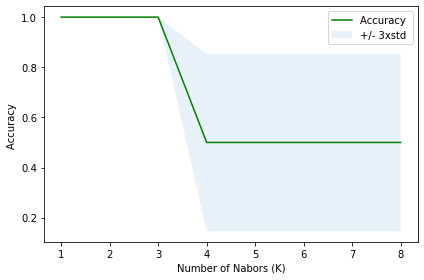

In [41]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

Where the maximum value is the one related with the __best k__. In the case of __Barcelona__, as we see, we should select __k=3__ (in equal accurancy for different k values we choose the __largest one__ that could fit better for our case). Repeating the same process for the other data sets, we found fro __Madrid k=8__ and for the data set for __both cities k=9__.

__Barcelona__

In [42]:
# set number of clusters
kclusters_bcn = 3

barcelona_grouped_clustering = barcelona_grouped_reduced_no_coor.drop('Neighbourhood', 1)

# run k-means clustering
kmeans_bcn = KMeans(n_clusters=kclusters_bcn, random_state=0).fit(barcelona_grouped_clustering)

barcelona_grouped_reduced_w_l = barcelona_grouped_reduced.copy()
barcelona_grouped_reduced_w_l.insert(0, 'Cluster Labels', kmeans_bcn.labels_)

# create map
map_clusters_bcn = folium.Map(location=[latitude_bcn, longitude_bcn], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters_bcn)
ys = [i + x + (i*x)**2 for i in range(kclusters_bcn)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(barcelona_grouped_reduced_w_l['Neighbourhood Latitude'], barcelona_grouped_reduced_w_l['Neighbourhood Longitude'], barcelona_grouped_reduced_w_l['Neighbourhood'], barcelona_grouped_reduced_w_l['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_bcn)
       
map_clusters_bcn

__Madrid__

In [43]:
# set number of clusters
kclusters_mad = 8

madrid_grouped_clustering = madrid_grouped_reduced_no_coor.drop('Neighbourhood', 1)

# run k-means clustering
kmeans_mad = KMeans(n_clusters=kclusters_mad, random_state=0).fit(madrid_grouped_clustering)

madrid_grouped_reduced_w_l = madrid_grouped_reduced.copy()
madrid_grouped_reduced_w_l.insert(0, 'Cluster Labels', kmeans_mad.labels_)

# create map
map_clusters_mad = folium.Map(location=[latitude_mad, longitude_mad], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters_mad)
ys = [i + x + (i*x)**2 for i in range(kclusters_mad)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_grouped_reduced_w_l['Neighbourhood Latitude'], madrid_grouped_reduced_w_l['Neighbourhood Longitude'], madrid_grouped_reduced_w_l['Neighbourhood'], madrid_grouped_reduced_w_l['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_mad)
       
map_clusters_mad

__Barcelona and Madrid__

In [44]:
# set number of clusters
kclusters_total = 9

total_grouped_clustering = total_grouped_red.drop('Neighbourhood', 1)

# run k-means clustering
kmeans_total = KMeans(n_clusters=kclusters_total, random_state=0).fit(total_grouped_clustering)

concat_total_red_frames_coor= [madrid_grouped_reduced, barcelona_grouped_reduced]
total_grouped_red_coor =pd.concat(concat_total_red_frames_coor)
total_grouped_red_coor_w_l = total_grouped_red_coor.copy()
total_grouped_red_coor_w_l.insert(0, 'Cluster Labels', kmeans_total.labels_)

In [45]:
# create map
map_clusters_total_bcn = folium.Map(location=[latitude_bcn, longitude_bcn], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters_total)
ys = [i + x + (i*x)**2 for i in range(kclusters_total)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(total_grouped_red_coor_w_l['Neighbourhood Latitude'], total_grouped_red_coor_w_l['Neighbourhood Longitude'], total_grouped_red_coor_w_l['Neighbourhood'], total_grouped_red_coor_w_l['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_total_bcn)
       
map_clusters_total_bcn

In [46]:
# create map
map_clusters_total_mad = folium.Map(location=[latitude_mad, longitude_mad], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters_total)
ys = [i + x + (i*x)**2 for i in range(kclusters_total)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(total_grouped_red_coor_w_l['Neighbourhood Latitude'], total_grouped_red_coor_w_l['Neighbourhood Longitude'], total_grouped_red_coor_w_l['Neighbourhood'], total_grouped_red_coor_w_l['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_total_mad)
       
map_clusters_total_mad

The poor districts of Madrid seem to not share similarities with the poor districts of Barcelona. The similarities between both cities that can be seen between the central areas of both cities.

We can have a look to the __top ten venues__ for each __poor__ district to understand and __compare__ them with the __wealthy ones__ with more venues to __figure out some solutions__ in order to improve the live of the people living on the poorest districts.

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

__Barcelona__

In [49]:
# create a new dataframe
barcelona_dist_venues_sorted_red = pd.DataFrame(columns=columns)
barcelona_dist_venues_sorted_red['Neighbourhood'] = barcelona_grouped_reduced_no_coor['Neighbourhood']

for ind in np.arange(barcelona_grouped_reduced_no_coor.shape[0]):
    barcelona_dist_venues_sorted_red.iloc[ind, 1:] = return_most_common_venues(barcelona_grouped_reduced_no_coor.iloc[ind, :], num_top_venues)

wealthy_bcn_top_10 = barcelona_dist_venues_sorted_red.iloc[[1,9]]
poor_bcn_top_10 = barcelona_dist_venues_sorted_red.iloc[[3,5,6]]

In [50]:
wealthy_bcn_top_10

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Eixample,Medical Center,Event Space,Art Gallery,Gym / Fitness Center,Gym,Park,Language School,Hospital,Yoga Studio,Theater
9,Sarria Sant Gervasi,Medical Center,Doctor's Office,Event Space,Park,Dentist's Office,Cultural Center,Music School,Gym / Fitness Center,Hospital,Language School


In [51]:
poor_bcn_top_10

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Horta Guinardo,Park,Cultural Center,Language School,Event Space,Medical Center,Dentist's Office,Music School,Gym / Fitness Center,Athletics & Sports,Doctor's Office
5,Nou Barris,Event Space,Park,Medical Center,Gym,Cultural Center,Language School,Gym / Fitness Center,Gym Pool,Escape Room,Doctor's Office
6,Sant Andreu,Park,Event Space,Medical Center,Language School,Cultural Center,Gym,Soccer Field,Dentist's Office,Music School,Veterinarian


__Madrid__

In [52]:
# create a new dataframe
madrid_dist_venues_sorted_red = pd.DataFrame(columns=columns)
madrid_dist_venues_sorted_red['Neighbourhood'] = madrid_grouped_reduced_no_coor['Neighbourhood']

for ind in np.arange(madrid_grouped_reduced_no_coor.shape[0]):
    madrid_dist_venues_sorted_red.iloc[ind, 1:] = return_most_common_venues(madrid_grouped_reduced_no_coor.iloc[ind, :], num_top_venues)

wealthy_mad_top_10 = madrid_dist_venues_sorted_red.iloc[[4,14]]
poor_mad_top_10 = madrid_dist_venues_sorted_red.iloc[[12,16,20]]

In [53]:
wealthy_mad_top_10

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Chamartin,Medical Center,Event Space,Doctor's Office,Park,Hospital,Gym / Fitness Center,Gym,Language School,Dentist's Office,Cultural Center
14,Salamanca,Medical Center,Gym / Fitness Center,Doctor's Office,Event Space,Gym,Hospital,Language School,Music School,Cultural Center,Dentist's Office


In [54]:
poor_mad_top_10

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Puente de Vallecas,Medical Center,Gym,Event Space,Park,Athletics & Sports,Dentist's Office,Language School,Rock Club,Doctor's Office,Concert Hall
16,Tetuan,Gym,Medical Center,Dentist's Office,Gym / Fitness Center,Doctor's Office,Dance Studio,Park,Event Space,Veterinarian,Gymnastics Gym
20,Villaverde,Medical Center,Park,Dance Studio,Art Gallery,Event Space,Doctor's Office,Dentist's Office,Veterinarian,Basketball Court,Athletics & Sports


## Results and Discussion <a name="results"></a>

Regarding the distribution of the net mean income we can obrserve that the __wealthy__ districts in __Madrid__ are located __west and east of the city center__, while the __poorest__ are located in the __south__ of Madrid and at the north of the city center. Barcelona has a different topography from Madrid. While Madrid is located in the center of the iberian peninsula, Barcelona is in the mediterranean cost. That can condition how the income is distributed in each city. Barcelona net incomes seems to be distributed along the Diagonal, the main venue that cross the city from the north-west to the south-east. The __wealthy__ districts in __Barcelona__ are over this avenue meanly in the __north-west__ side and the __neuralgic center__ of the city, while the __poorest__ are all located in the __north-east__ of the city.

When analyzing the __venues distribution__ we found that many of then are more correlated with they income. After droping the less __relevant venues__ we can see that for __Barcelona__ the __mathcing__ between the reduced venues map and the income are __very close__. __Madrid__ shows a __less clear__ image than Barcelona. It seems that __Madrid concentrated__ the most of the __venues__ close to the __city center__ independiently for the income level of the districts, while __Barcelona__ seems to be more __homogenuesly distributed__. This information will be helpful when discussing the similarity between both cities or the posible actions to imporve the poorest districts.

Regarding the __clustering__ of the __Madrid__ districts, the __poorest__ districts are separeted into __three__ different __clusters__, being the cluster 1 for Villaverde the one most close to the income image, and for the wealthy  one cluster 7 where the district Moncloa-Aravaca was located. In the case of __Barcelona__ there are __three clusters that meets prety well the income distribution__ of the city. On __cluster 0 we have all the poorest districts__ Sant Andreu, Horta Guinardo and Nou Barris, on cluster 1 the Eixample and other medium income level districts and __on cluster 2 the two most wealthy districts__ Sarria-San Gervasi and Les Corts. So we can clearly identify that the __poorest districts of Barcelona are very similar__, while for __Madrid are distributed into heterogenous gorups__. When analyzing __together all the districts__ for both cities, the image of __Barcelona didn't change__, while __Madrid get more close to the income distribution__. As we can see for __Madrid, now the poorest district are only distributed into two groups__, but still are mixed with other more wealthy districts. Tetuan is inside the culster 8 and Villaverde and Puente de Vallecas are inside cluster 0. __The only similarity between both cities are located in their city center__. Both city center are located into the same cluster, number 2, which consists on Madrid-Centro/Arganzuela from Madrid and Eixample/Ciutat Vella/Gracia/Sant Marti/Sants-Montjouic. __Any poor district are related between both cities__.

Having a look to the top ten venues for each district, __Barcelona poorest districts__ maybe have a lack of __health care services__ comparing with the wealthy ones. While for __Madrid poorest districts__ seemto have a different problem with a lack of venues related to the __cultural and educational__ ones. Looking at the top ten for the poorest districts of Madrid, we can see that __districts on different clusters were more similar that we think__.

## Conclusion <a name="conclusion"></a>

We can __conclude__ that __Madrid and Barcelona districts__ are, in general, quite __different__ especially the poorest ones. __Only the city centers of both cities seem to share a strong similarity__. Thus, in priciple, __a common strategy cannot be defined between the two cities__.

If we compare the poorest district inside each city, we conclude theat the __poorest districts of Barcelona can be grouped together__ but the poorest districts of __Madrid not__. Thus, __commons actions for the poorest districts of Barcelona__ can be taken, while in principle for Madrid is not possible but after looking at the top ten venues for the poorest districts of Madrid we can observe a __lack of similar kind of venues__ for the two clusters inside Madrid.

A solution for __Barcelona__ poorest districts can be to __increase the health care services__, while for __Madrid__ the solution could be to __increase cultural and educational venues__.